# Evaluation of the complete pipeline

In this notebook we evaluation the combination of the combined face detector and mask/no_mask classifier pipeline.  

We evaluate performance as follows: 

      For each image in the validation set, do the following:  
          1. Fetch the cropped faces that are the result of the RetinaFace face detector (see prep-data.ipynb)
          2. Apply the current classification model to these cropped faces to obtain a mask/no_mask prediction
          3. Compare these predictions to the ground truth face bounding boxes and corresponding predictions:
              For each ground truth face bounding box, look for an overlapping (IoU > 0.5) bounding box produced by the face detector
              If such a bounding box is found, we can compare the predicted label for that bounding box to the ground truth label (resulting in TP, FP, TN or FN for this particular image)
              If such a bounding box is not found, we keep track of this in a separate variable
          4. Check if there are also bounding boxes produced by the face detector that do not match any ground-truth bounding boxes.
             If this happens, we keep track of this in a separate variable as well.
             


## Imports

In [88]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.mobilenet import MobileNet
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.mobilenet import preprocess_input

import keras 

from sklearn import metrics 
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import itertools
import random
from collections import namedtuple
import os

## Setup

In [109]:
target_size = (112,112)
batch_size = 32
lr = 0.01
n_epochs = 2 

root_dir = os.path.dirname(os.path.abspath(os.curdir))
data_dir = Path(root_dir) / 'data'

model_dir = data_dir / 'models'
model_dir.mkdir(exist_ok=True)

performance_plots_dir = Path('img')
performance_plots_dir.mkdir(exist_ok=True)

prediction_plot_dir = Path('data_dir/overall_model_evaluation/predictions')
plot_dir_correct = prediction_plot_dir / 'all_correct'
plot_dir_correct.mkdir(exist_ok=True, parents=True)
plot_dir_mistake = prediction_plot_dir / 'mistake'
plot_dir_mistake.mkdir(exist_ok=True, parents=True)

real_validation_dir = data_dir / 'validation' / 'real'
real_test_dir = data_dir / 'test'

## Create validation and test generators

In [90]:
metadata = pd.read_csv(data_dir / 'test_validation_metadata.csv')

In [91]:
# we need both the ground truth and detector bounding boxes to evaluate the IoU 
detector_bboxes = pd.read_csv(data_dir / 'detector_annotations.csv')
ground_truth_boxes = pd.read_csv(data_dir / 'image_annotations.csv')

In [92]:
val_frame_real = pd.DataFrame(columns=['original_image','bbox_id','x','y','w','h','class','image'])

for row_idx, row in metadata.iterrows():
    if not 'validation' in row.cropped_img_dir:
        continue
    fn = Path(row.cropped_img_dir).name
    detector_bboxes_fn = detector_bboxes[detector_bboxes.img == fn]
    for d_idx, d_row in detector_bboxes_fn.iterrows():
        val_frame_real.loc[len(val_frame_real)] = [fn,d_row.bbox_id,d_row.x, d_row.y, d_row.w, d_row.h, 'none', d_row.crop_fn]

In [93]:
test_frame_real = pd.DataFrame(columns=['original_image','bbox_id','x','y','w','h','class','image'])

for row_idx, row in metadata.iterrows():
    if not 'test' in row.cropped_img_dir:
        continue
    fn = Path(row.cropped_img_dir).name
    detector_bboxes_fn = detector_bboxes[detector_bboxes.img == fn]
    for d_idx, d_row in detector_bboxes_fn.iterrows():
        test_frame_real.loc[len(test_frame_real)] = [fn,d_row.bbox_id,d_row.x, d_row.y, d_row.w, d_row.h, 'none', d_row.crop_fn]

In [94]:
val_datagen_real = ImageDataGenerator(preprocessing_function=preprocess_input)
val_frame_real.image = val_frame_real.image.astype(str)
val_generator_real = val_datagen_real.flow_from_dataframe(val_frame_real, 
                                                shuffle=False,
                                                target_size=target_size,
                                                x_col='image')

Found 265 validated image filenames belonging to 1 classes.


In [95]:
test_datagen_real = ImageDataGenerator(preprocessing_function=preprocess_input)
test_frame_real.image = test_frame_real.image.astype(str)
test_generator_real = test_datagen_real.flow_from_dataframe(test_frame_real, 
                                                shuffle=False,
                                                target_size=target_size,
                                                x_col='image')

Found 246 validated image filenames belonging to 1 classes.


## Evaluation code

TODO: explain here why all this is needed: matching bounding boxes, keeping track of stats, ...

In [110]:
def bb_intersection_over_union(boxA, boxB):
    """
    Computes the IoU between two bounding boxes
    from https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    """
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [97]:
def compare_pred_to_groundtruth(true_boxes, true_labels, pred_boxes, pred_scores, include_missed=False, classification_threshold=0.5, iou_threshold=0.5):
    """
    Compares predicted bounding boxes and their labels to ground truth bounding boxes and labels for a single image.
    
    We have a set of ground truth bounding boxes and their corresponding labels,
    and a set of predicted bounding boxes and predicted labels.
    However, these sets do not match. In this function we will do the matching and compute performance statistics.
    We will also return ground truth labels and matched predictions, so that they can be further used to compute other statistics (e.g. ROC).
    
    Keyword arguments:
    true_boxes -- ground truth face bounding boxes
    true_labels -- ground truth mask/no_mask labels corresponding to these bounding boxes
    pred_boxes -- bounding boxes produced by the face detector
    pred_scores -- predictions made by the mask/no_mask classifier for the boxes produced by the face detector
    include_missed -- whether to include faces that are missed by the face detector in the returned matched labels and predictions
                      use False if you only want to evaluate the mask/no_mask classifier
                      use True if you want to evaluate the detector + classifier,
                      in this case we will simply predict 1 (i.e. masked) for each face that is not found
    classification_threshold -- predictions > this threshold are labeled masked, lower as unmasked
    iou_threshold -- predicted bounding boxes are assumed to match ground truth boxes if their IoU > this threshold    
    """
    
    matched_gt_labes = []
    matched_pred_scores = []
    
    # performance statistics for when ground-truth bounding boxes are matched with predicted boxes
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    
    # performance statistics for when they are not
    n_masked_faces_that_dont_exist = 0 # detector produced bounding box that does not match face, predicted as masked
    n_non_masked_faces_that_dont_exist = 0 # detector produced bounding box that does not match face, predicted as unmasked 
    n_non_masked_not_identified = 0 # ground-truth bounding box did not match with any of the detector's bounding boxes, ground-truth was non masked
    n_masked_not_identified = 0 # same as line above, but ground-truth label was wasked
    
    # edge cases that occur when a face is matched with multiple detector bounding boxes
    n_masked_labeled_as_both = 0 # in principle there can be two bounding boxes partially covering the same face, which can then be labeled differently
    n_non_masked_labeled_as_both = 0 # same as line above, but for non-masked ground-truth
    n_masked_correctly_detected_multiple_times = 0 
    n_masked_wrongly_detected_multiple_times = 0 
    n_non_masked_wrongly_detected_multiple_times = 0
    n_non_masked_correctly_detected_multiple_times = 0
    
    # for each ground-truth box, we compare to all the predicted boxes
    # to find matches (IoU > threshold)
    for gt_box, gt_label in zip(true_boxes, true_labels):
        
        # compare the ground-truth box with all predicted boxes
        times_found_correct_label = 0
        times_found_incorrect_label = 0 
        for pred_box, pred_score in zip(pred_boxes, pred_scores): 
            pred_label = pred_score > classification_threshold
            iou = bb_intersection_over_union(gt_box, pred_box)
            
            if iou > iou_threshold:
                matched_gt_labes.append(gt_label)
                matched_pred_scores.append(pred_score)
            
            if iou >= iou_threshold and gt_label == pred_label:
                times_found_correct_label += 1
            elif iou >= iou_threshold and gt_label != pred_label:
                times_found_incorrect_label += 1
                
        # now that we have matched the boxes and compared labels,
        # we can compute statistics
        times_found_total = times_found_correct_label + times_found_incorrect_label
        if gt_label == 1:
            # the ground-truth is masked face
            if times_found_total == 0:
                n_masked_not_identified += 1
                if include_missed:
                    matched_gt_labes.append(1)
                    matched_pred_scores.append(1)
            elif times_found_correct_label == 0 and times_found_incorrect_label > 0:
                fn += 1
                n_masked_wrongly_detected_multiple_times += 1
            elif times_found_correct_label > 0 and times_found_incorrect_label == 0:
                tp += 1
                n_masked_correctly_detected_multiple_times += times_found_correct_label - 1
            elif times_found_correct_label > 0 and times_found_incorrect_label > 0:
                n_masked_labeled_as_both += 1
        elif gt_label == 0:
            # the ground-truth is unmasked face
            if times_found_total == 0:
                n_non_masked_not_identified += 1
                if include_missed:
                    matched_gt_labes.append(0)
                    matched_pred_scores.append(1)
            elif times_found_correct_label == 0 and times_found_incorrect_label > 0:
                fp += 1
                n_non_masked_wrongly_detected_multiple_times += times_found_incorrect_label - 1
            elif times_found_correct_label > 0 and times_found_incorrect_label == 0:
                tn += 1
                n_non_masked_correctly_detected_multiple_times += times_found_correct_label - 1
            elif times_found_correct_label > 0 and times_found_incorrect_label > 0:
                n_non_masked_labeled_as_both += 1
                
    # we also have to check for detected bounding boxes that do not overlap with any ground truth bounding box
    for pred_box, pred_score in zip(pred_boxes, pred_scores):
        pred_label = pred_score > classification_threshold
        
        found = False
        for gt_box, gt_label in zip(true_boxes, true_labels):
            iou = bb_intersection_over_union(gt_box, pred_box)
            if iou > iou_threshold:
                found = True
                break
                
        if not found:
            if pred_label == 1:
                n_masked_faces_that_dont_exist += 1
            else:
                n_non_masked_faces_that_dont_exist += 1
    
    Stats = namedtuple('Stats', ['tp', 'fp', 'tn', 'fn', 
                             'n_masked_not_identified',
                             'n_non_masked_not_identified',
                             'n_masked_faces_that_dont_exist',
                             'n_non_masked_faces_that_dont_exist', 
                             'n_masked_labeled_as_both',
                             'n_non_masked_labeled_as_both',
                             'n_masked_correctly_detected_multiple_times',
                             'n_masked_wrongly_detected_multiple_times',
                             'n_non_masked_wrongly_detected_multiple_times',
                             'n_non_masked_correctly_detected_multiple_times'])
    return Stats(tp,fp,tn,fn,
                 n_masked_not_identified,
                 n_non_masked_not_identified,
                 n_masked_faces_that_dont_exist,
                 n_non_masked_faces_that_dont_exist,
                 n_masked_labeled_as_both,
                 n_non_masked_labeled_as_both,
                 n_masked_correctly_detected_multiple_times,
                 n_masked_wrongly_detected_multiple_times,
                 n_non_masked_wrongly_detected_multiple_times,
                 n_non_masked_correctly_detected_multiple_times), matched_gt_labes, matched_pred_scores

In [98]:
def plot_img(fn, true_boxes, true_labels, pred_boxes, pred_labels):
    """
    Plot the results of the face detector and mask/no_mask classifier as well as ground-truth face boxes.
    
    Keyword arguments:
    fn -- path to the image for which predictions are made
    true_boxes -- ground-truth face bounding boxes
    true_label -- ground-truth labels
    pred_boxes -- bounding boxes produced by face detector
    pred_labels -- predictions made by mask/no_mask classifier for bounding boxes produced by face detector
    """
    img = cv2.imread(str(fn))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure()
    plt.imshow(img/255)
    
    for x1, y1, x2, y2 in true_boxes:
        rect = plt.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=3,edgecolor='black',facecolor='none')
        plt.gca().add_patch(rect)
        
    for (x1, y1, x2, y2), predicted_mask in zip(pred_boxes, pred_labels):
        rect = plt.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=3, edgecolor='green' if predicted_mask else 'red',facecolor='none')
        plt.gca().add_patch(rect)
   
    output_dir = plot_dir_correct if true_labels == pred_labels else plot_dir_mistake
    plt.axis('off')
    plt.savefig(output_dir / fn.name, bbox_inches='tight', pad_inches=0)
    plt.close()

In [99]:
def compute_validation_statistics(model, val_gen, val_df, plot=False, include_missed=False, classification_threshold=0.5):
    """
    Apply a model to the validation data (generated by val_gen and described in more detail in val_df) and print performance statistics.
    Also returns matched ground truth labels and pipeline prediction scores.
    
    
    Keyword arguments:
    model -- the model to evaluate
    val_gen -- generates the validation data
    val_df -- should give additional info on validation data
    plot -- if this is True an image will be produced in prediction_plot_dir with ground truth bounding boxes,
            as well as predicted bounding boxes
    include_missed -- whether to include faces that are missed by the face detector in the returned matched labels and predictions
          use False if you only want to evaluate the mask/no_mask classifier
          use True if you want to evaluate the detector + classifier,
          in this case we will simply predict 1 (i.e. masked) for each face that is not found
    classification_threshold -- predictions > this threshold are classified as masked
    """
    
    pred = model.predict_generator(val_gen)
   
    # prepare the prediction dataframe for merging with val_df
    pred_df = pd.DataFrame({'img' : val_gen.filenames,
                            'pred' : np.squeeze(pred)})
    
    # from the cropped img name (e.g. 100_0.jpg) to the original image name (e.g. 100.jpg)
    pred_df['original_image'] = pred_df.img.apply(lambda x: x.split('/')[-1].split('_')[0] + '.jpg') 
    
    # extract the bbox id, e.g. cropped image 100_0.jpg corresponds to 0th extracted face bbox
    # we need this id because the ground truth annotations reference them 
    pred_df['bbox_id'] = pred_df.img.apply(lambda x: int(x.split('/')[-1].split('_')[1].split('.')[0]))

    pred_df['predicted_class'] = pred_df.pred.apply(lambda x: 1 if x > classification_threshold else 0)

 
    # merging with val_df to get one dataframe with both the class predictions and detector bounding box coordinates
    pred_df = pred_df.merge(val_df, left_on=['original_image', 'bbox_id'], right_on=['original_image', 'bbox_id'])
    
    # performance statistics for when ground-truth bounding boxes are matched with predicted boxes
    tp_tot = 0
    fp_tot = 0
    fn_tot = 0
    tn_tot = 0

    # performance statistics for when they are not
    n_masked_faces_that_dont_exist = 0
    n_non_masked_faces_that_dont_exist = 0
    n_masked_not_identified = 0
    n_non_masked_not_identified = 0
    
    # edge cases that occur when a face is matched with multiple detector bounding boxes
    n_masked_correctly_detected_multiple_times = 0
    n_masked_wrongly_detected_multiple_times = 0
    n_non_masked_wrongly_detected_multiple_times = 0
    n_non_masked_correctly_detected_multiple_times = 0
    n_masked_labeled_as_both = 0
    n_non_masked_labeled_as_both = 0
    
    
    matched_gt_labels = []
    matched_pred_scores = []

    # loop over all the validation images to compare ground-truth bounding boxes
    # to predicted ones in that image
    val_img_ids = set(val_df.original_image)
    for val_img_id in val_img_ids:
        
        # first collect ground truth bounding boxes and labels in a nicer format
        img_ground_truth = ground_truth_boxes[ground_truth_boxes.img == val_img_id]
        true_labels = []
        true_boxes = []
        for idx, row in img_ground_truth.iterrows():
            true_labels.append(1 if row['class'] == 'with_mask' else 0)
            true_boxes.append((row.x, row.y, row.x + row.w, row.y + row.h))

        # do the same for the predictions
        img_pred = pred_df[pred_df.original_image == val_img_id]
        pred_labels = []
        pred_boxes = []
        pred_scores = []
        for idx, row in img_pred.iterrows():
            pred_labels.append(row.predicted_class)
            pred_boxes.append((row.x, row.y, row.x + row.w, row.y + row.h))
            pred_scores.append(row.pred)

        if plot:
            plot_img(data_dir / 'raw_images' / val_img_id, true_boxes, true_labels, pred_boxes, pred_labels)
       
        # get the performance statistics for this image
        stats, cur_gt, cur_scores = compare_pred_to_groundtruth(true_boxes, true_labels, pred_boxes, pred_scores, include_missed, classification_threshold)

        matched_gt_labels.extend(cur_gt)
        matched_pred_scores.extend(cur_scores)
        
        tp_tot += stats.tp
        fp_tot += stats.fp
        fn_tot += stats.fn
        tn_tot += stats.tn
        
        n_masked_faces_that_dont_exist += stats.n_masked_faces_that_dont_exist
        n_non_masked_faces_that_dont_exist += stats.n_non_masked_faces_that_dont_exist
        n_masked_labeled_as_both += stats.n_masked_labeled_as_both
        n_non_masked_labeled_as_both += stats.n_non_masked_labeled_as_both
        n_masked_correctly_detected_multiple_times += stats.n_masked_correctly_detected_multiple_times
        n_masked_wrongly_detected_multiple_times += stats.n_masked_wrongly_detected_multiple_times
        n_non_masked_wrongly_detected_multiple_times += stats.n_non_masked_wrongly_detected_multiple_times
        n_non_masked_correctly_detected_multiple_times += stats.n_non_masked_correctly_detected_multiple_times
        n_masked_not_identified += stats.n_masked_not_identified
        n_non_masked_not_identified += stats.n_non_masked_not_identified
                
    
    print(f"\n====\nEvaluation of the face detector\n====")
    print(f"The detector found {n_masked_faces_that_dont_exist} masked faces that don't exist")
    print(f"The detector found {n_non_masked_faces_that_dont_exist} non-masked faces that don't exist")
    
    print(f"{n_masked_not_identified} masked faces were not identified by the detector")
    print(f"{n_non_masked_not_identified} non-masked faces were not identified by the detector\n")
    
    print("\n====\nEvaluation of the mask/no_mask classifier:\n====")
    print("On the ground truth-bounding boxes that were identified by the detector, we have the following stats: ")
    print(f"True positives: {tp_tot}")
    print(f"True negatives: {tn_tot}")
    print(f"False positives: {fp_tot}")    
    print(f"False negatives: {fn_tot}")
    acc = (tp_tot + tn_tot) / (tp_tot + tn_tot + fp_tot + fn_tot)
    print(f"Resulting in the following accuracy on the *detected* faces: {acc:.2f}\n")
    
          
    print("\n====\nGlobal evaluation:\n====")
    tnr = tn_tot / (tn_tot + fp_tot + n_non_masked_not_identified)
    print(f"TNR: {100*tnr:.1f}%, i.e. {100*tnr:.1f}% of the unmasked faces were detected")
    
    fnr = fn_tot / (tp_tot + fn_tot + n_masked_not_identified)
    print(f"FNR: {100*fnr:.1f}%, i.e. {100*fnr:.1f}% of masked faces were wrongly identified as unmasked faces")
    
    print(f"Additionally, {n_non_masked_faces_that_dont_exist} unmasked faces were detected for which there was no matching face in the ground truth")

    return matched_gt_labels, matched_pred_scores
 

In [101]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    From: https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def print_stats(true_labels, pred, classification_threshold=0.5):
    """
    Print some performance statistics.
    """
    pred_bin = [x > classification_threshold for x in pred]
    acc = metrics.accuracy_score(true_labels, pred_bin)
    print(f"Accuracy = {acc:.3f}")

    cm = metrics.confusion_matrix(true_labels, pred_bin)
    plt.figure()
    plot_confusion_matrix(cm, ['not masked', 'masked'])
    plt.savefig(performance_plots_dir / 'confusion.png', bbox_inches='tight', pad_inches=0)
    
    fpr, tpr, thr = metrics.roc_curve(true_labels, pred)
    auc = metrics.auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=15)
    plt.ylabel('True Positive Rate', size=15)
    plt.title(f'AUC = {auc:.3f}', size=15)
    plt.savefig(performance_plots_dir / 'roc.png', bbox_inches='tight', pad_inches=0)

## Load model

In [ ]:
best_model = keras.models.load_model(model_dir / 'best.h5')

## On validation set

In [102]:
gt_ordered, scores_ordered = compute_validation_statistics(best_model,val_generator_real, val_frame_real, plot=False)


====
Evaluation of the face detector
====
The detector found 5 masked faces that don't exist
The detector found 4 non-masked faces that don't exist
3 masked faces were not identified by the detector
8 non-masked faces were not identified by the detector


====
Evaluation of the mask/no_mask classifier:
====
On the ground truth-bounding boxes that were identified by the detector, we have the following stats: 
True positives: 111
True negatives: 116
False positives: 24
False negatives: 4
Resulting in the following accuracy on the *detected* faces: 0.89


====
Global evaluation:
====
TNR: 78.4%, i.e. 78.4% of the unmasked faces were detected
FNR: 3.4%, i.e. 3.4% of masked faces were wrongly identified as unmasked faces
Additionally, 4 unmasked faces were detected for which there was no matching face in the ground truth


Accuracy = 0.891


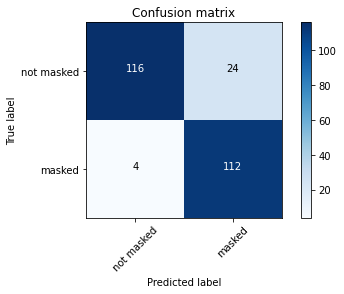

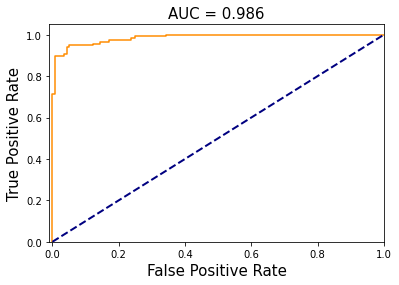

In [103]:
print_stats(gt_ordered, scores_ordered)

## On test set

In [104]:
gt_ordered, scores_ordered = compute_validation_statistics(best_model,test_generator_real, test_frame_real, plot=False)


====
Evaluation of the face detector
====
The detector found 9 masked faces that don't exist
The detector found 6 non-masked faces that don't exist
10 masked faces were not identified by the detector
8 non-masked faces were not identified by the detector


====
Evaluation of the mask/no_mask classifier:
====
On the ground truth-bounding boxes that were identified by the detector, we have the following stats: 
True positives: 103
True negatives: 106
False positives: 16
False negatives: 6
Resulting in the following accuracy on the *detected* faces: 0.90


====
Global evaluation:
====
TNR: 81.5%, i.e. 81.5% of the unmasked faces were detected
FNR: 5.0%, i.e. 5.0% of masked faces were wrongly identified as unmasked faces
Additionally, 6 unmasked faces were detected for which there was no matching face in the ground truth


Accuracy = 0.905


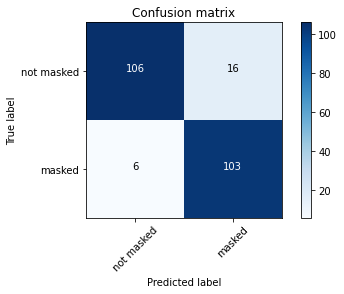

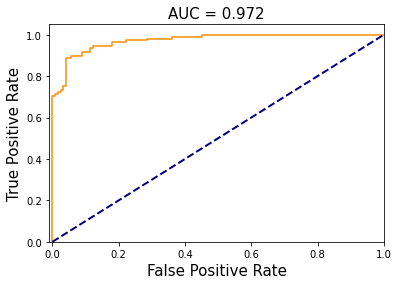

In [105]:
print_stats(gt_ordered, scores_ordered)

In [106]:
gt_ordered, scores_ordered = compute_validation_statistics(best_model,test_generator_real, test_frame_real, plot=True)


====
Evaluation of the face detector
====
The detector found 9 masked faces that don't exist
The detector found 6 non-masked faces that don't exist
10 masked faces were not identified by the detector
8 non-masked faces were not identified by the detector


====
Evaluation of the mask/no_mask classifier:
====
On the ground truth-bounding boxes that were identified by the detector, we have the following stats: 
True positives: 103
True negatives: 106
False positives: 16
False negatives: 6
Resulting in the following accuracy on the *detected* faces: 0.90


====
Global evaluation:
====
TNR: 81.5%, i.e. 81.5% of the unmasked faces were detected
FNR: 5.0%, i.e. 5.0% of masked faces were wrongly identified as unmasked faces
Additionally, 6 unmasked faces were detected for which there was no matching face in the ground truth


## Plot some examples

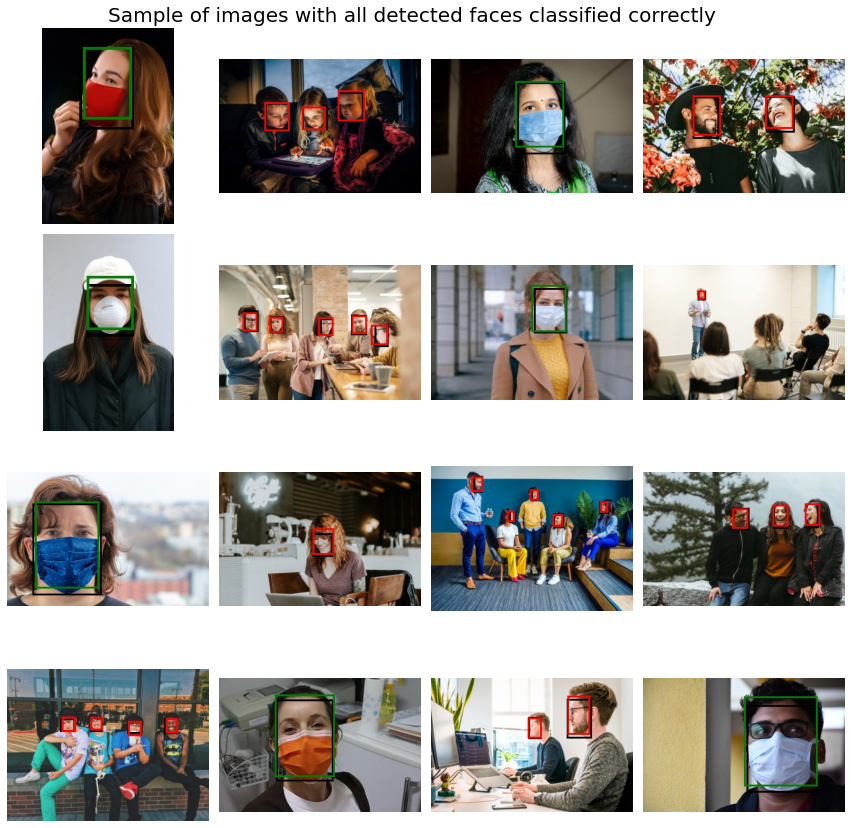

In [107]:
n_to_plot = 16
all_correct_pred = list(plot_dir_correct.glob('*.jpg'))
to_plot = random.sample(all_correct_pred,n_to_plot)

nrow = np.ceil(np.sqrt(n_to_plot))
ncol = nrow

plt.figure(figsize=(15,15))
for idx, x in enumerate(to_plot):
    plt.subplot(nrow, ncol, idx+1)
    img = cv2.imread(str(x))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle('Sample of images with all detected faces classified correctly', size=20, y=0.9)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

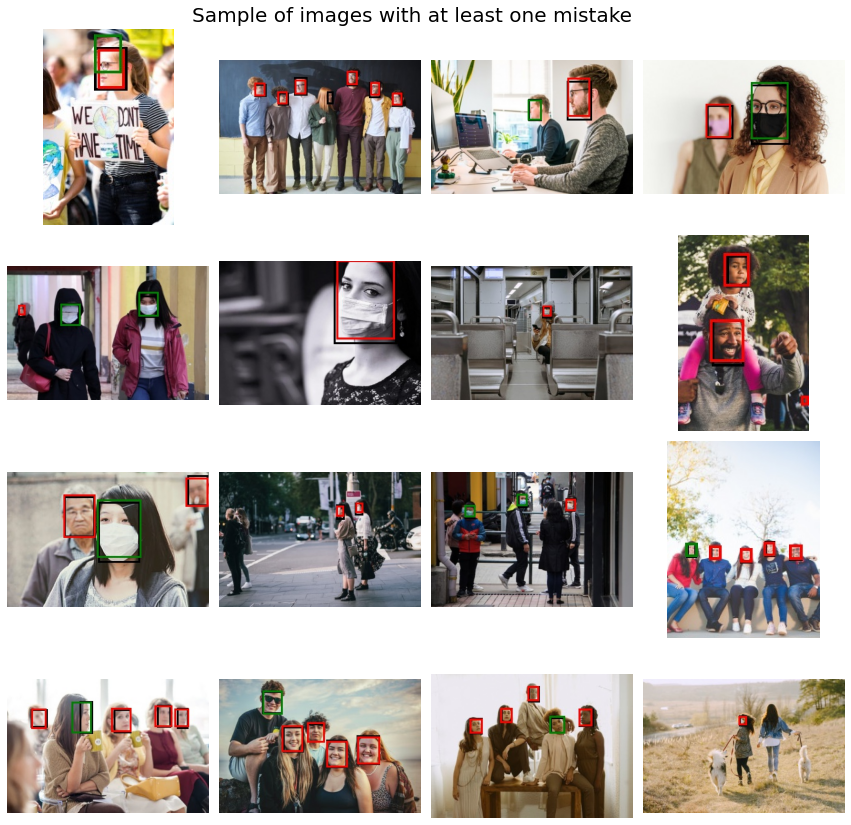

In [108]:
n_to_plot = 16
all_mistake_pred = list(plot_dir_mistake.glob('*.jpg'))
to_plot = random.sample(all_mistake_pred,n_to_plot)

nrow = np.ceil(np.sqrt(n_to_plot))
ncol = nrow

plt.figure(figsize=(15,15))
for idx, x in enumerate(to_plot):
    plt.subplot(nrow, ncol, idx+1)
    img = cv2.imread(str(x))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle('Sample of images with at least one mistake', size=20, y=0.9)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()